<a href="https://colab.research.google.com/github/bulatych/ML_HSE/blob/main/homeworks/HW_6_(clustering_%26_reduction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all, a few notes:
* As before, no code hints. We trust your skills (if in doubt - check the seminar notebook).
* Remember to submit the feedback! Especially if the homework was too difficult or easy for you.

# Introduction <font color=#c30>**[1.0]**</font>




## scRNA-seq

We **must** know our data before doing the analysis. To ease your life, [here](https://www.singlecellcourse.org/introduction-to-single-cell-rna-seq.html) is an excellent state-of-the-art description of the scRNA-seq experiments. Read it and answer the following questions:

* <font color=#c30>**[0.2]**</font> What is single-cell RNA-seq and how does it compare to bulk RNA-seq?

bulk RNA-seq allows profiling the transcripts in samples composed of a mixture of cells. For example, it can be used to characterise expression signatures between tissues in healthy/diseased. It estimates the average expression level for each gene across a population of cells.

With scRNA-seq we can estimate a distribution of expression levels for each gene across a population of cells.  We can see the heterogeneity in gene expression across individual cells of some sample. So we can analyze where cell-specific changes in the transcriptome are important or not.

* <font color=#c30>**[0.2]**</font>  What are some of the typical applications of scRNA-seq?

 Using scRNA-seq we can discover new or rare cell types, identify differential cell composition between healthy/diseased tissues or understand cell differentiation during development. Also it can be used in spatial and  functional mapping: combining scRNA-seq with spatial transcriptomic techniques to map gene expression to specific tissue regions. It helps with profiling tumor microenvironment to distinguish cancer cells from stromal and immune cells within a tumor.

* <font color=#c30>**[0.2]**</font>  What experimental design choices should be considered in scRNA-seq?

→ Two most important aspects are cell capture or isolation and transcript quantification.

The choice of cell capture strategy—microtitre-plate-based, microfluidic-array-based, or microfluidic-droplet-based—determines experimental throughput, cell selection process, and additional data that can be obtained beyond transcript sequencing.

Before cell capture Fluorescence Activated Cell Sorting (FACS) can be used to select a subpopulation of cells. For example, it can be used to stain the cells with a dye that distinguishes between live and dead cells in order to enrich the cell suspension with viable cells.

The choice of quantification method has important implications for what types of analyses the data can be used for. Full-length protocols try to achieve a uniform read coverage across the whole transcript, whereas tag-based protocols only capture either the 5’ or 3’ ends.

In general factors such as the cost per cell, how many cells one needs, or how much to sequence each cell, may all influence on choice of protocol.


* <font color=#c30>**[0.2]**</font>  What are some of the challenges of scRNA-seq data compared to bulk data?
-  Due to low RNA capture efficiency, scRNA-seq data often suffer from dropout events where genes expressed in a cell are not detected, data contains many zeros

- There is no way to have “biological replicates” at a single-cell level: each cell is unique and impossible to replicate

- Batch effects. These can be observed even when sequencing the same material using different technologies, and if not properly normalised, can lead to incorrect conclusions.

- Important to avoid confounding between experimentally controlled variables  and the time when the samples are prepared and sequenced.  Availability replication of tissue samples.

## Target experiment

To move on, you need to find/choose and download your favorite scRNA-seq dataset. Similar to what we did during the workshop, but everyone will have their own data to make it more fun.

See, for example, public [10x datasets](https://www.10xgenomics.com/resources/datasets?menu%5Bproducts.name%5D=Single%20Cell%20Gene%20Expression&query=&page=1&configure%5Bfacets%5D%5B0%5D=chemistryVersionAndThroughput&configure%5Bfacets%5D%5B1%5D=pipeline.version&configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000&refinementList%5Bproduct.name%5D%5B0%5D=Single%20Cell%20Gene%20Expression) or [GEO](https://www.ncbi.nlm.nih.gov/gds/?term=scRNA-seq). Subsample cells or use more strict thresholds if the computations are too long.

* <font color=#c30>**[0.2]**</font>  Please provide a brief description of the chosen dataset. I.e., what was the purpose of the original study, what is the protocol, and so on. Insert link to the dataset.

→ [Dataset](https://www.10xgenomics.com/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) describes human peripheral blood mononuclear cells (PBMCs) of a healthy female donor aged 25-30, which were obtained by 10x Genomics from AllCells.

Libraries were generated from ~16,000 cells (11,485 cells recovered) as described in the Chromium Single Cell 3' Reagent Kits User Guide (v3.1 Chemistry Dual Index) (CG000315 Rev C) using the Chromium Controller and sequenced on an Illumina NovaSeq 6000 to a read depth of approximately 30,000 mean reads per cell.

Paired-end, dual indexing Read 1: 28 cycles (16 bp barcode, 12 bp UMI) i5 index: 10 cycles (sample index) i7 index: 10 cycles (sample index) Read 2: 90 cycles (transcript)

Analysis Parameters Used: Run with --expect-cells=10000.

# Main flow <font color=#c30>**[7.5]**</font>

Simple and tedious, you need to repeat the seminar results with your data and implement some algorithms by hand.

* <font color=#c30>**[2.5]**</font>  Repeat the main workflow: load & preprocess the data -> calculate PCA, UMAP, t-SNE -> color cells using K-means / Agg. Clustering / Leiden algorithms.





In [37]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz
!tar -xzf 10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz

--2024-12-17 12:48:08--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93346135 (89M) [application/x-tar]
Saving to: ‘10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz.1’

10k_PBMC_3p_nextgem 100%[===================>]  89.02M   134MB/s    in 0.7s    

2024-12-17 12:48:09 (134 MB/s) - ‘10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz.1’ saved [93346135/93346135]



In [38]:
!ls filtered_feature_bc_matrix

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


In [39]:
# current plt is not supported by the scanpy
!python3 -m pip uninstall -y matplotlib
!python3 -m pip install matplotlib==3.6.3 scanpy

Found existing installation: matplotlib 3.6.3
Uninstalling matplotlib-3.6.3:
  Successfully uninstalled matplotlib-3.6.3
  Using cached matplotlib-3.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached matplotlib-3.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.3 which is incompatible.
plotnine 0.14.3 requires matplotlib>=3.8.0, but you have matplotlib 3.6.3 which is incompatible.


In [40]:
import scanpy as sc

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3

adata = sc.read_10x_mtx(
    'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True                     # write a cache file for faster subsequent reading
)
# Make all gene names unique (symbols MUST be unique by but in reality...)
adata.var_names_make_unique()

adata

... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types'

## Filtering

In [41]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

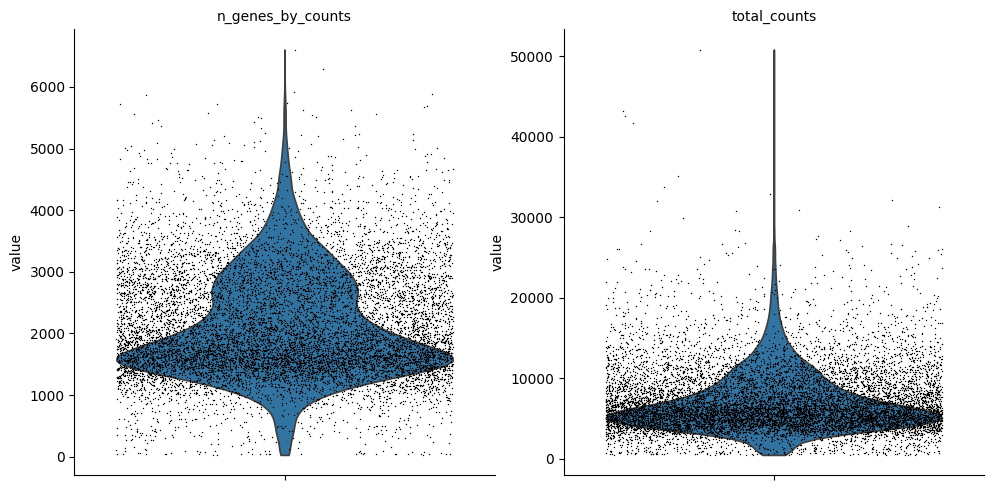

In [42]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts'],
    jitter=0.4, multi_panel=True
)

In [43]:
# Warning! Very harsh thresholds to keep comp. time small
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=100)
adata

filtered out 528 cells that have less than 1000 genes expressed
filtered out 24028 genes that are detected in less than 100 cells


AnnData object with n_obs × n_vars = 10957 × 12573
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [44]:
adata.var

,gene_ids,feature_types,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL627309.5,ENSG00000241860,Gene Expression,473,0.043796,95.881585,503.0,470
LINC01409,ENSG00000237491,Gene Expression,743,0.071136,93.530692,817.0,731
LINC01128,ENSG00000228794,Gene Expression,558,0.051633,95.141489,593.0,540
LINC00115,ENSG00000225880,Gene Expression,119,0.010710,98.963866,123.0,118
FAM41C,ENSG00000230368,Gene Expression,131,0.011667,98.859382,134.0,130
...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695,Gene Expression,3889,0.502394,66.138441,5770.0,3744
MT-CYB,ENSG00000198727,Gene Expression,11482,45.538181,0.026121,523006.0,10957
AL592183.1,ENSG00000273748,Gene Expression,975,0.090727,91.510666,1042.0,966
AC240274.1,ENSG00000271254,Gene Expression,253,0.023248,97.797127,267.0,253


In [45]:
adata.obs['n_genes']

,n_genes
AAACCCAAGGTAGTCG-1,1749
AAACCCACAATCCAGT-1,3742
AAACCCACACCGTCTT-1,2110
AAACCCACATAGATCC-1,1452
AAACCCACATCTCATT-1,2992
...,...
TTTGTTGGTTTACGTG-1,1128
TTTGTTGTCCACAGGC-1,2080
TTTGTTGTCCCGAGGT-1,3396
TTTGTTGTCTGTACAG-1,1526


In [46]:
mask = adata.var_names.str.startswith('MT-')
print(f"Mito genes: {adata.var_names[mask].tolist()}")

adata.var['mt'] = mask

Mito genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [47]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

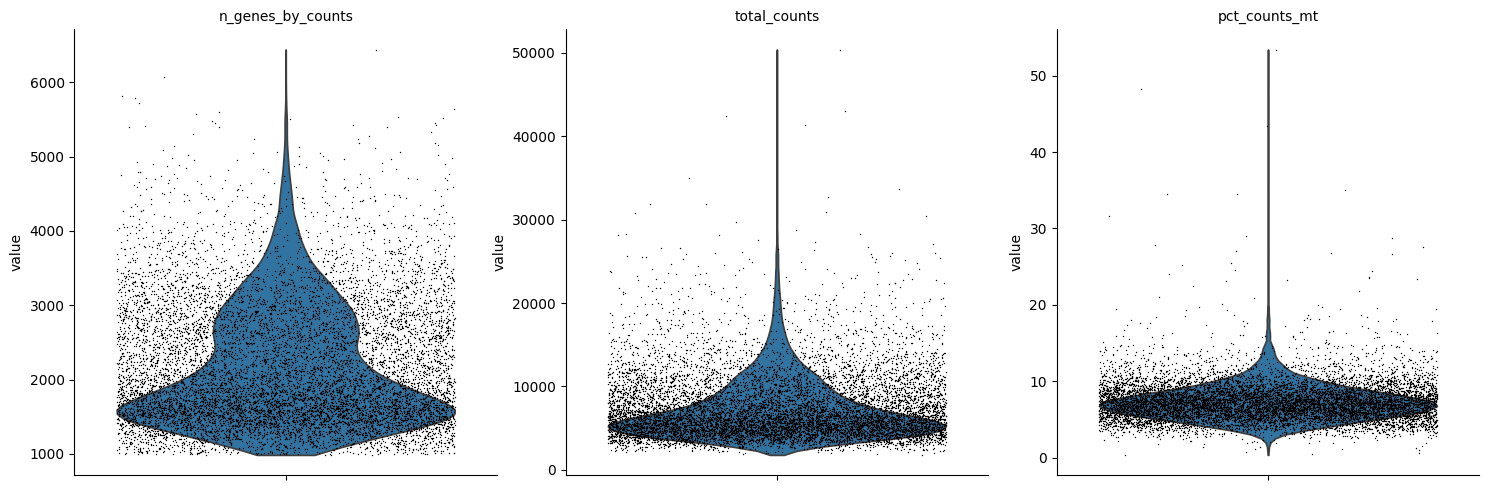

In [48]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True
)

In [49]:
# Apply filters
adata = adata[adata.obs.n_genes_by_counts < 4_500, :]
adata = adata[adata.obs.total_counts < 24_000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

View of AnnData object with n_obs × n_vars = 9672 × 12573
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt'

In [50]:
# Normalize the data to CPM & take the log
sc.pp.normalize_total(adata, target_sum=1e6) # sum(cell counts) = 1e6
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


We aren't done yet. Before moving on, we need to eliminate genes that are, in some sense, too ordinary. For example, the expression of housekeeping genes and other low-variance genes is comparable in many cells. Therefore their information value is negligible, and we can save a lot of computations by removing them early on.

In [51]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=7, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


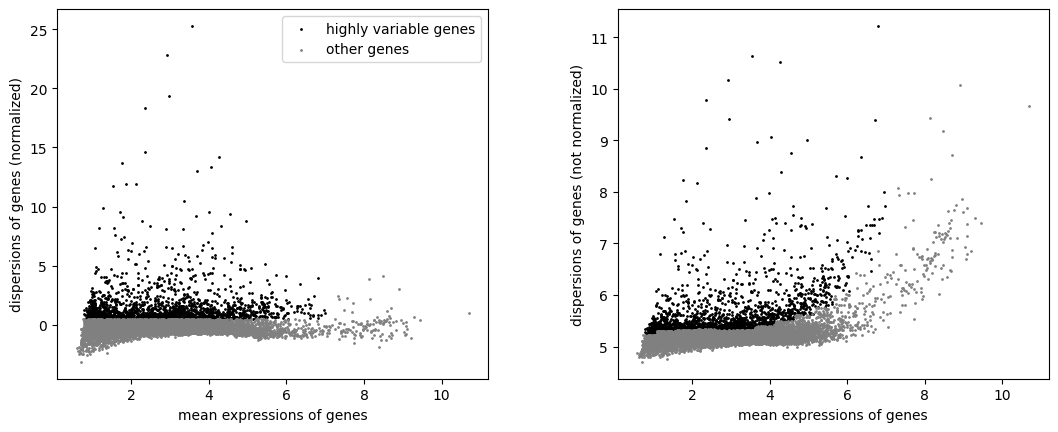

In [52]:
sc.pl.highly_variable_genes(adata)

In [53]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 9672 × 1825
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [54]:
sc.pp.scale(adata, max_value=10) # clip values > 10

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Manifold Learning

In [55]:
import numpy as np
# Subsample to speed up the analysis
ind = np.random.choice(np.arange(len(adata.X)), 2_000, replace=False)

X = adata.X[ind].copy()
print(f"Cells vs Genes: {X.shape}")

Cells vs Genes: (2000, 1825)


In [56]:
from sklearn.manifold import Isomap, MDS, TSNE, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.decomposition import PCA

# Set of models to work with
embeddings = {
    "Isomap embedding": Isomap(n_components=2),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=100),
    "t-SNE embedding": TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42),
    "Spectral embedding": SpectralEmbedding(n_components=2, random_state=32),
    "LLE embedding": LocallyLinearEmbedding(n_components=2, method="modified"),
    "PCA": PCA(n_components=2)
}

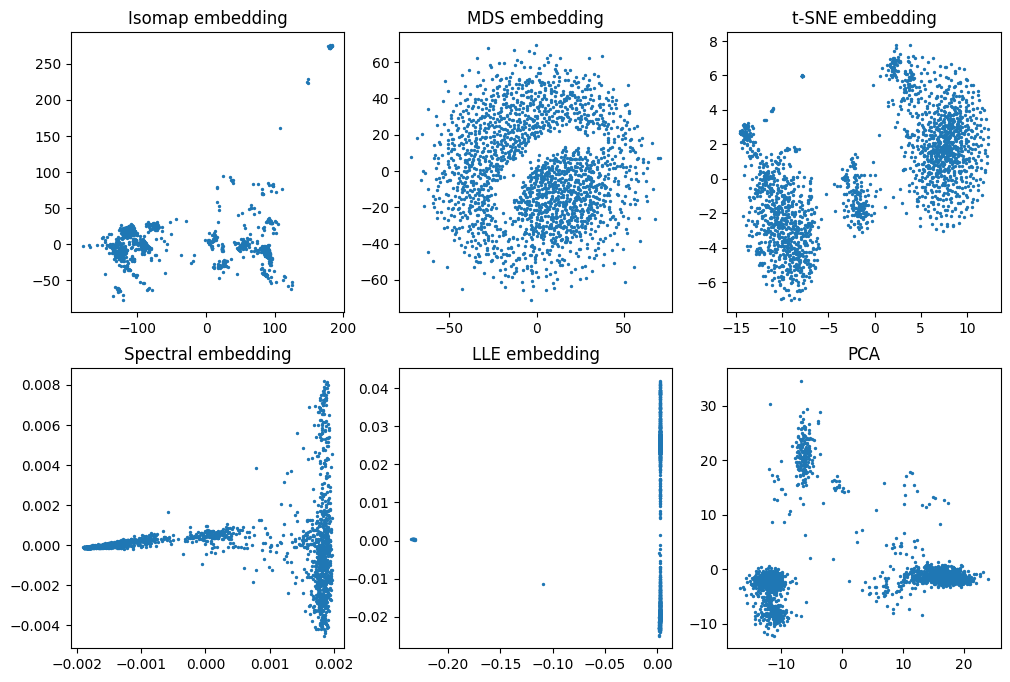

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

assert len(axes) == len(embeddings)

for ax, (name, model) in zip(axes, embeddings.items()):
  ax.set_title(name)
  transformed = model.fit_transform(X)
  ax.scatter(transformed[:, 0], transformed[:, 1], s=2)

computing PCA
    with n_comps=50
    finished (0:00:04)


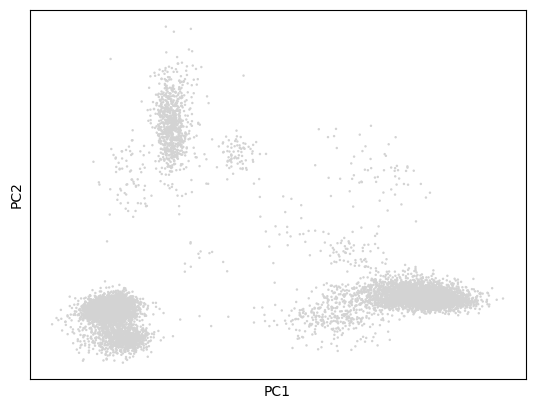

In [58]:
sc.tl.pca(adata)
sc.pl.pca(adata)

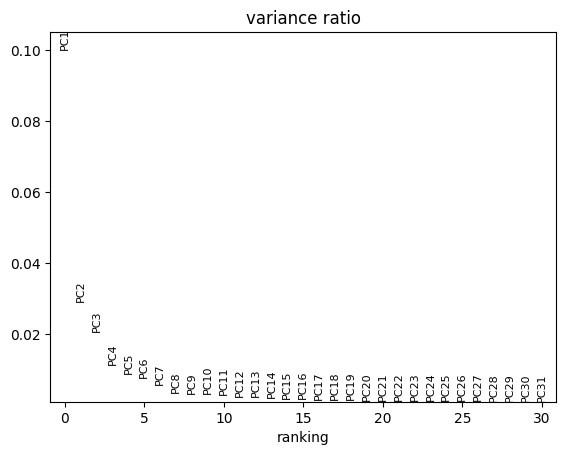

In [59]:
sc.pl.pca_variance_ratio(adata)

In [60]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:20)


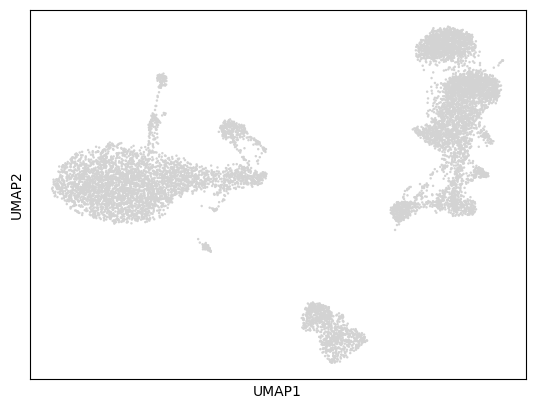

In [61]:
sc.pl.umap(adata)

Loosely speaking, clustering algorithms try to find groups of elements in a way to maximize the dissimilarity between groups and similarity within each group. The problem is, of course, how to measure the similarity and find the best combination of items, which is an NP-hard optimization problem.

As in the case of dimensionality reduction, there are many options, and the specific choice usually depends on the problem being solved.

## Clustering

In [62]:
# Subsample to speed up the analysis
sample = sc.pp.subsample(adata, n_obs=5_000, copy=True)
sample

AnnData object with n_obs × n_vars = 5000 × 1825
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [63]:
!python3 -m pip install leidenalg

Plot the results


* <font color=#c30>**[1]**</font>  Make several plots showing how the representation of data is changing for UMAP & t-SNE by tweaking parameters of those algorithms. For the representation of your choice, find optimal number of clusters by tweaking `n_clusters` in K-means and `resolution` in Leiden algorithm. What was the optimal number of clusters for your dataset? Justify your choice.

IMAP parameters:
- `n_neighbors` — determines how many nearest neighbors to use to determine the local data structure.
- `min_dist` — affects the compactness of clusters.

First, let's tweak `min_dist` param

Графики UMAP для разных значений min_dist:


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


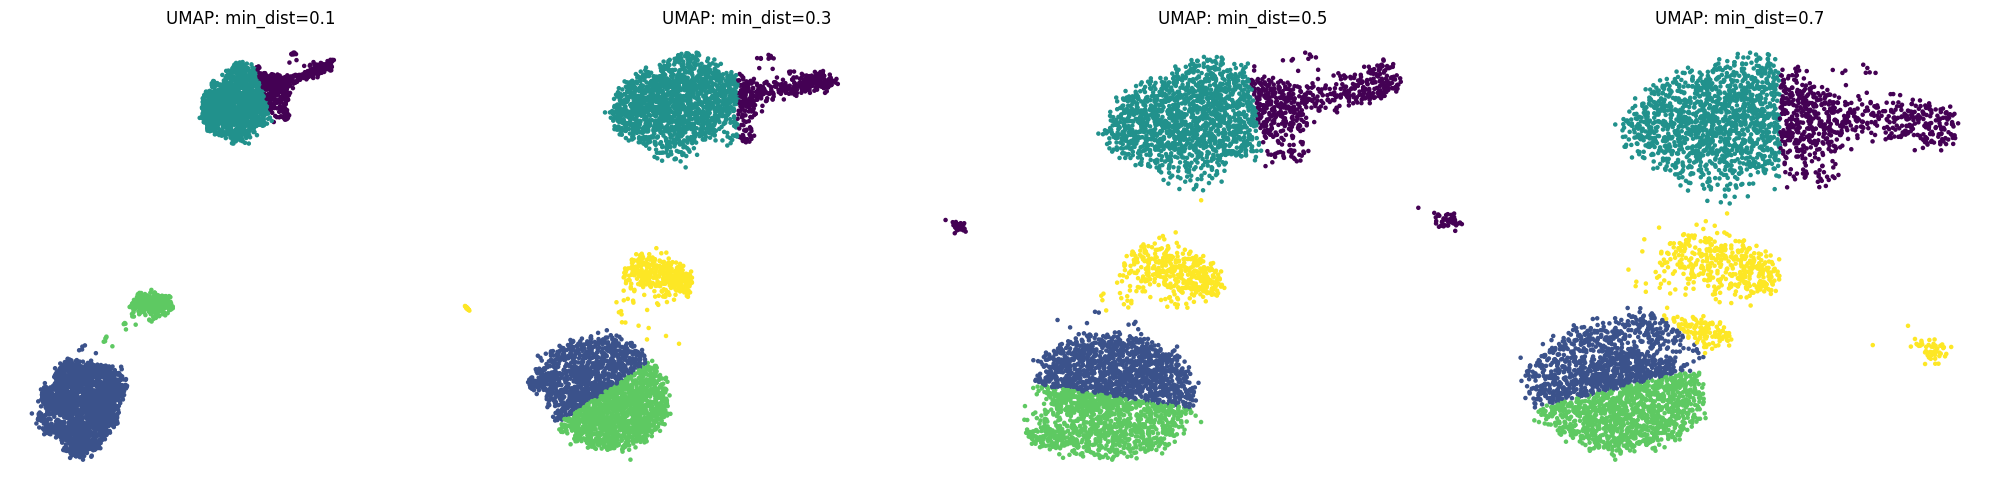

In [87]:
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Функция для построения графиков UMAP с разными min_dist
def plot_umap_min_dist_only(min_dist_values, n_clusters=5):
    n_plots = len(min_dist_values)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    axes = axes.ravel()

    for i, min_dist in enumerate(min_dist_values):
        # UMAP для снижения размерности (без n_neighbors)
        reducer = umap.UMAP(min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(sample.X)

        # KMeans для кластеризации
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embedding)

        # Визуализация
        ax = axes[i]
        ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=5)
        ax.set_title(f"UMAP: min_dist={min_dist}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Построение графиков для различных min_dist
print("Графики UMAP для разных значений min_dist:")
plot_umap_min_dist_only(min_dist_values=[0.1, 0.3, 0.5, 0.7], n_clusters=5)





From the images obtained, it can be seen that the boundaries of some clusters look too suspiciously smooth. Most likely, this is one cluster and there should be no border. There is no such boundary for min_dist -0.1. Let's take this parameter as a standard one

Now let's tune `n_neighbours` param

Графики UMAP для разных значений n_neighbors:


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


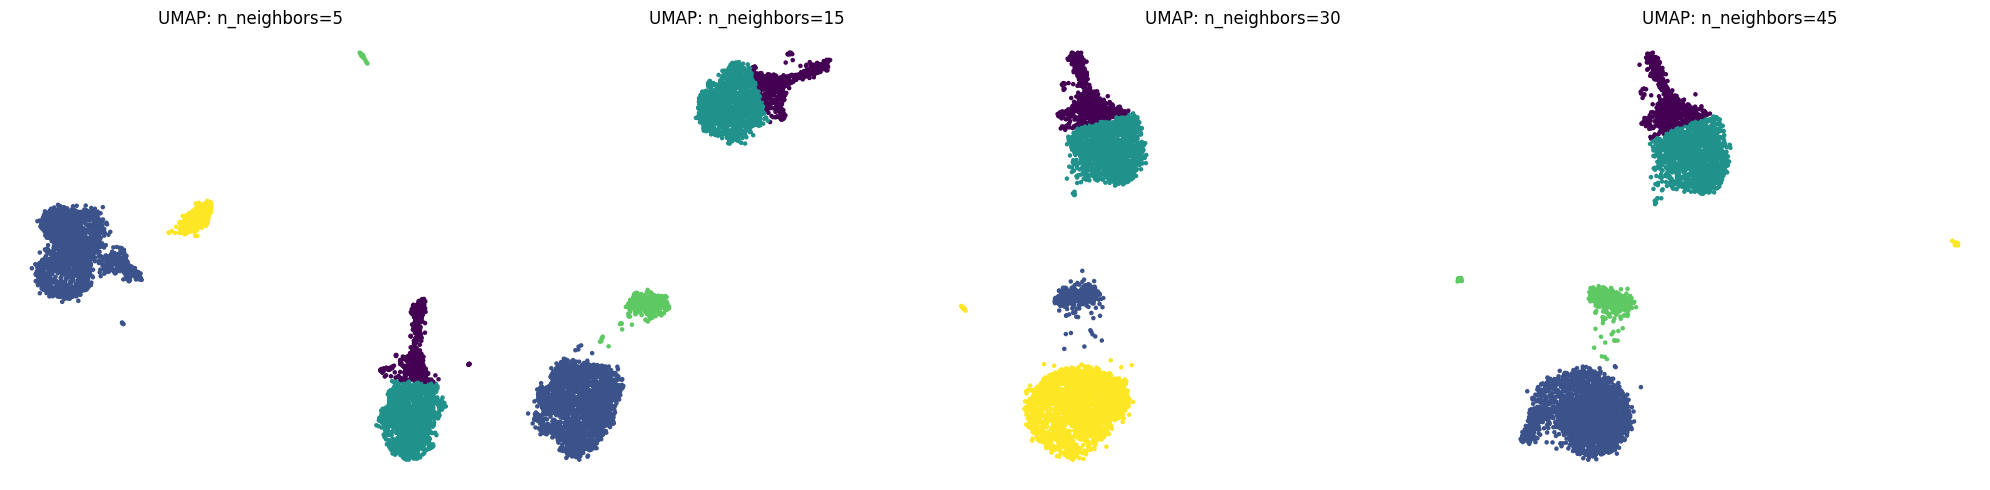

In [65]:
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Функция для построения графиков UMAP с разными n_neighbors
def plot_umap_n_neighbors_only(n_neighbors_values, min_dist=0.1, n_clusters=5):
    n_plots = len(n_neighbors_values)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    axes = axes.ravel()

    for i, n_neighbors in enumerate(n_neighbors_values):
        # UMAP для снижения размерности с разными n_neighbors
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(sample.X)

        # KMeans для кластеризации
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embedding)

        # Визуализация
        ax = axes[i]
        ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=5)
        ax.set_title(f"UMAP: n_neighbors={n_neighbors}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Построение графиков для различных n_neighbors
print("Графики UMAP для разных значений n_neighbors:")
plot_umap_n_neighbors_only(n_neighbors_values=[5, 15, 30, 45], min_dist=0.1, n_clusters=5)


The standard value for `n_neighbours` UMAP is usually 15. Let's continue working with it

tSNE Parameters:

- `perplexity` — sets the balance between the local and global data structure.
- `learning_rate` — learning rate (usually selected in the range of 10-1000).

Графики t-SNE для разных значений perplexity:


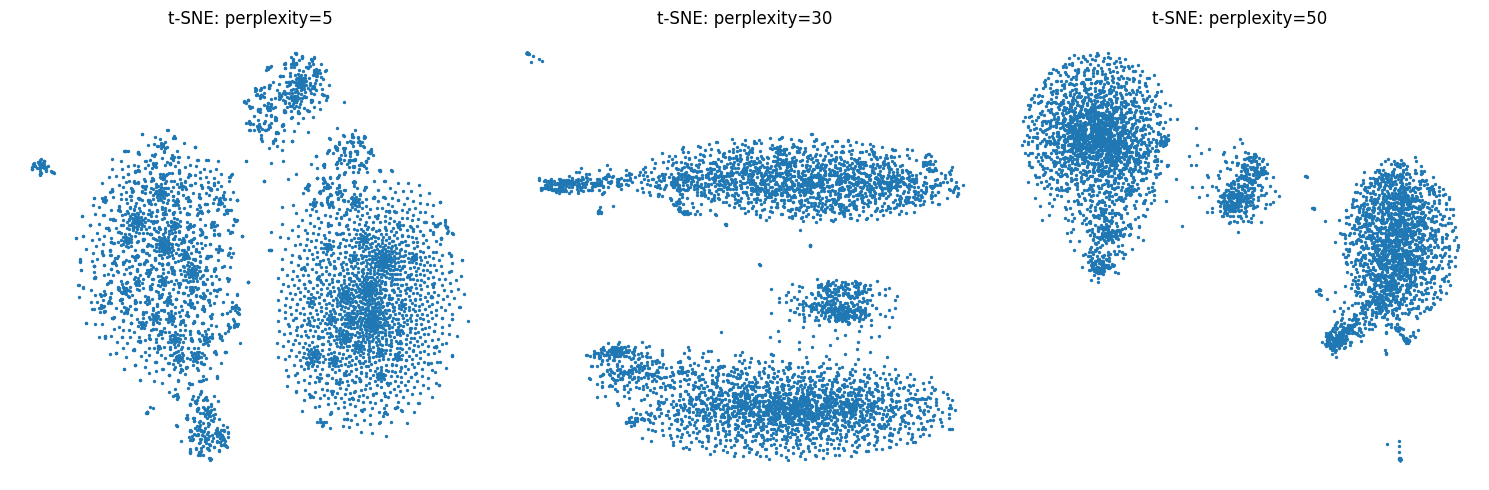

Графики t-SNE для разных значений n_pcs:


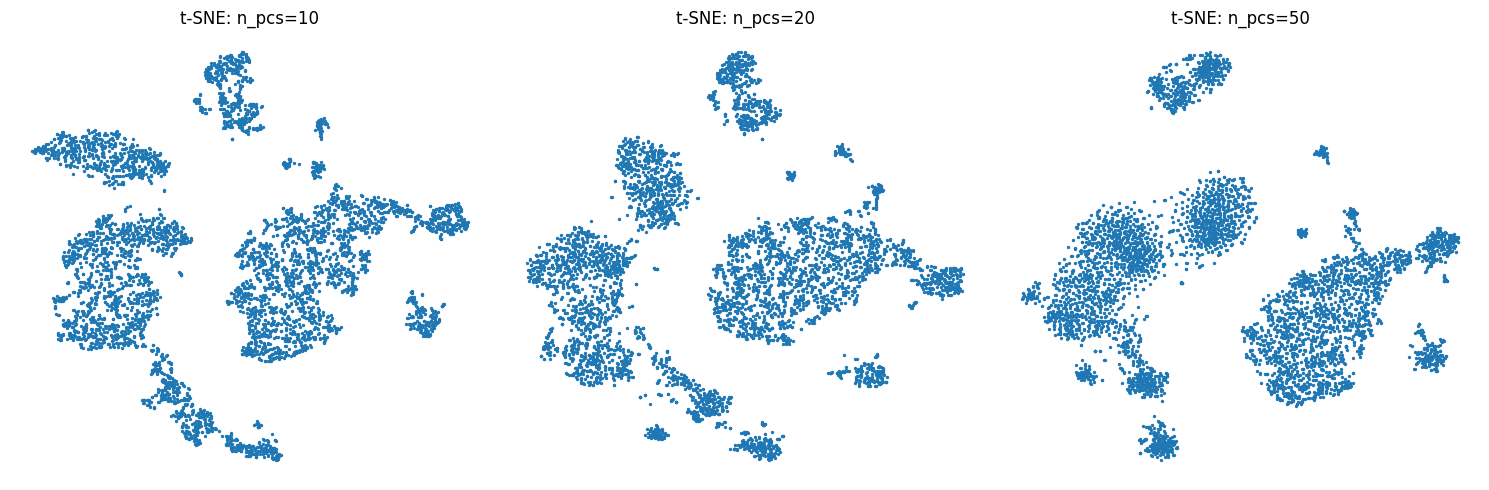

In [66]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Функция для построения t-SNE с разными perplexity
def plot_tsne_perplexity(perplexity_values, learning_rate=200):
    n_plots = len(perplexity_values)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    axes = axes.ravel()

    for i, perplexity in enumerate(perplexity_values):
        tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, random_state=42)
        embedding = tsne.fit_transform(sample.X)

        ax = axes[i]
        ax.scatter(embedding[:, 0], embedding[:, 1], s=2)
        ax.set_title(f"t-SNE: perplexity={perplexity}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Функция для построения t-SNE с разными n_pcs
def plot_tsne_n_pcs(n_pcs_values, perplexity=30, learning_rate=200):
    n_plots = len(n_pcs_values)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    axes = axes.ravel()

    for i, n_pcs in enumerate(n_pcs_values):
        # Снижение размерности с помощью PCA перед t-SNE
        pca = PCA(n_components=n_pcs, random_state=42)
        reduced_data = pca.fit_transform(sample.X)

        tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, random_state=42)
        embedding = tsne.fit_transform(reduced_data)

        ax = axes[i]
        ax.scatter(embedding[:, 0], embedding[:, 1], s=2)
        ax.set_title(f"t-SNE: n_pcs={n_pcs}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Построение графиков для разных perplexity
print("Графики t-SNE для разных значений perplexity:")
plot_tsne_perplexity(perplexity_values=[5, 30, 50], learning_rate=200)

# Построение графиков для разных n_pcs
print("Графики t-SNE для разных значений n_pcs:")
plot_tsne_n_pcs(n_pcs_values=[10, 20, 50], perplexity=30, learning_rate=200)


Comparison  of two approaches:

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


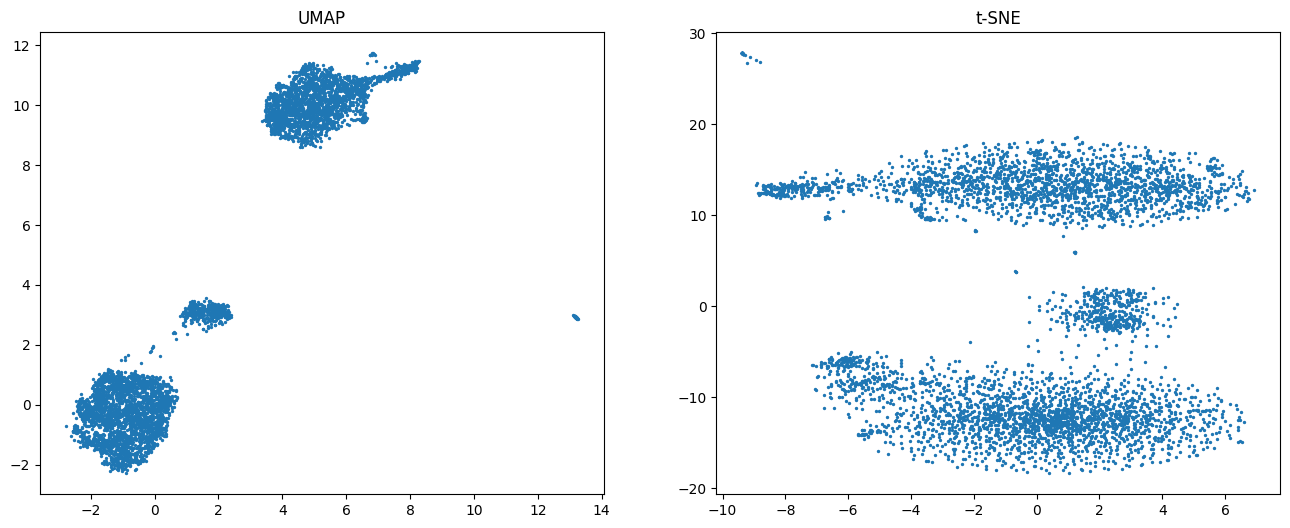

In [67]:
# UMAP
reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = reducer_umap.fit_transform(sample.X)

# t-SNE
from sklearn.manifold import TSNE
tsne_embedding = TSNE(perplexity=30, n_pcs =20, learning_rate=200, random_state=42).fit_transform(sample.X)

# Comparision
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=2)
axes[0].set_title("UMAP")
axes[1].scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=2)
axes[1].set_title("t-SNE")
plt.show()


**Comparison of tSNE and UMAP**

UMAP:
- Fast and scalable solution.
- Save both global and local data structures.
- To use when the data contains a large number of points.
- To use when we want to have more control over the compactness of clusters (via min_dist).

Example of the task: Clustering of unicellular data, where both local (similarity of cells in clusters) and global (cluster groups) connections are important.

tSNE:
- The main focus is on local structures (for example, separation within a cluster group).
- The data is relatively small (tSNE does not scale well for big data).
- An exceptionally good separation of dense clusters is needed.

For futher analysis I will choose UMAP algorithm because from several plots it seems UMAP betters splits the data into organized clusters. Also it works faster

Now let's find **optimal parametrs** both for K-means and Leigen algorithms

## K-means

To define optimal k-neighbours  I will use 2 different approaches.

**1.** Visualisation of "elbow" plot:

The "elbow" graph (inertia) estimates how the internal variance changes with an increase in the number of clusters.

**2.** Calculation and visualisation of silhouette coefficient

The average silhouette coefficient evaluates the quality of clustering (the closer to 1, the better).

In [68]:
sample.X

array([[-0.27237797,  0.7040916 , -0.19335353, ..., -0.11777611,
        -0.1511317 , -0.48887542],
       [-0.27237797, -1.1238412 , -0.19335353, ..., -0.11777611,
        -0.1511317 , -0.48887542],
       [-0.27237797,  0.6285408 , -0.19335353, ..., -0.11777611,
        -0.1511317 , -0.48887542],
       ...,
       [-0.27237797, -1.1238412 , -0.19335353, ..., -0.11777611,
        -0.1511317 , -0.48887542],
       [-0.27237797, -1.1238412 , -0.19335353, ..., -0.11777611,
        -0.1511317 , -0.48887542],
       [-0.27237797,  1.1636962 , -0.19335353, ..., -0.11777611,
        -0.1511317 ,  2.156944  ]], dtype=float32)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


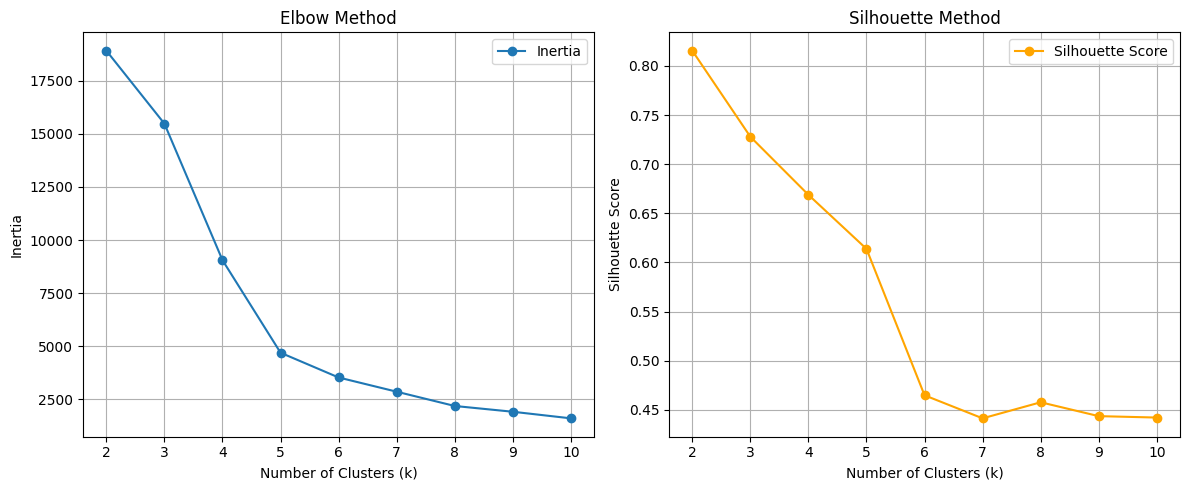

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Диапазон числа кластеров
k_values = range(2, 11)

# Метрики для оценки
inertia = []
silhouette_scores = []

# UMAP для визуализации
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(sample.X)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)

    # Сохраняем значения inertia и силуэтного коэффициента
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embedding, cluster_labels))

# График "локтя"
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'o-', label='Inertia')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid()
plt.legend()

# График силуэтного коэффициента
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'o-', label='Silhouette Score', color='orange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Looking for the point on the 'elbow' graph where there is a sharp slowdown in the decrease in inertia.This is the point where increasing the number of clusters does not significantly improve cluster density, that is, adding clusters does not significantly improve data partitioning. This point will be the optimal number of clusters (k = 5)

On the sceond graph for each point, the silhouette coefficient S(i) is calculated, which is defined as the difference between the average density of points within the cluster and the average density of points closest to neighboring clusters, relative to the maximum of these two values. If S(i)≈1: the point is located inside its cluster and is well separated from the others.

So, analyzing both plots I will choose k=5 as optimal amount of classes.  Silhouette not maximum, but if we choose 4 we can see that some variation in data remains undisclosed (cells can be split on more groups).


**Visualisation for K-means k=5**

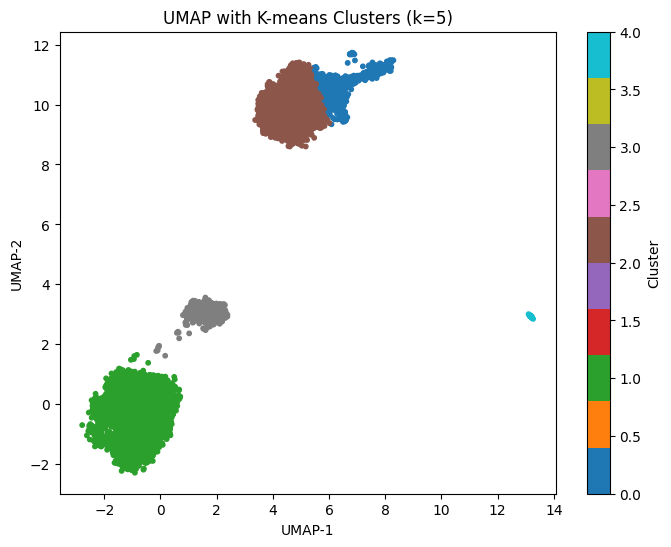

In [70]:
best_k = 5  # Optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP with K-means Clusters (k={best_k})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## Leigen

First, let's look a general understanding of how sensitive the algorithm is to resolution parameter.

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 6 cluster

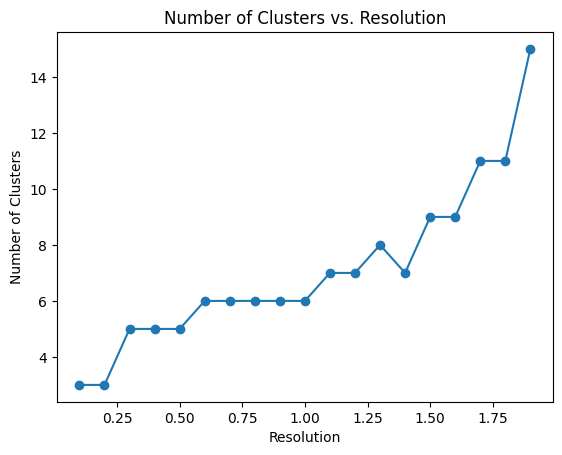

In [92]:
resolution_values = np.arange(0.1, 2.0, 0.1)
n_clusters = []

for resolution in resolution_values:
    sc.tl.leiden(sample, resolution=resolution)
    n_clusters.append(len(sample.obs['leiden'].unique()))

plt.plot(resolution_values, n_clusters, marker='o')
plt.xlabel('Resolution')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Resolution')
plt.show()


According to plot let's choose `resolution` = 0,5

**Visualisation for optimal_resolution = 0.5**

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


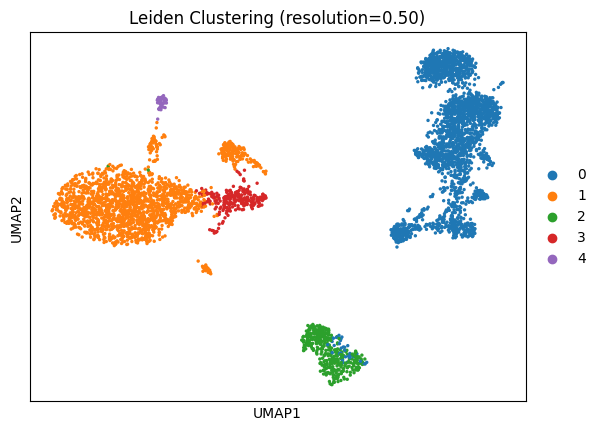

In [99]:
optimal_resolution = 0.5

sc.tl.leiden(sample, resolution=optimal_resolution)
sc.pl.umap(sample, color='leiden', title=f"Leiden Clustering (resolution={optimal_resolution:.2f})")


So, for Leiden algorithm witth resolution 0.5 also gives 5 clusters. Increasing resolution gives inadequate cluster separation

* <font color=#c30>**[1.5]**</font>  Analyze your clusters and identify if any of them is an outlier in terms of technical scRNA characteristics, such as:  number of UMIs per cell, number of genes per cell, percentage of mitochondrial expression? Are there any clusters with high doublet scores? Make relevant visualizations showcasing those differences.

  * If there are, what is the best way to deal with them? Are the differences between the cluster you selected and the other clusters reliable?


In [102]:
import numpy as np

# Проверка NaN в данных
print("NaN values in data:", np.isnan(sample.X).sum())

# Проверка нулевых строк
zero_cells = np.sum(sample.X.sum(axis=1) == 0)
print("Cells with zero counts:", zero_cells)


NaN values in data: 0
Cells with zero counts: 0


In [108]:
sample

AnnData object with n_obs × n_vars = 5000 × 1825
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'kmeans_cluster', 'leiden_cluster'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_cluster', 'rank_genes_groups', 'leiden_cluster_colors', 'dendrogram_leiden_cluster'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [107]:
# Запускаем Scrublet для выявления дупликатов
sc.pp.scrublet(sample)  # Автоматически добавляет 'doublet_score' и 'predicted_doublet' в obs

# Проверяем распределение doublet_score и количество предсказанных дупликатов
print(sample.obs['doublet_score'].describe())  # Описательные статистики
print(sample.obs['predicted_doublet'].value_counts())  # Число дупликатов



Running Scrublet
normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


extracting highly variable genes


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:383: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

## K-means

Размер sample: (5000, 1825)
kmeans_cluster
2    1918
3    1772
4     495
1     473
0     342
Name: count, dtype: int64


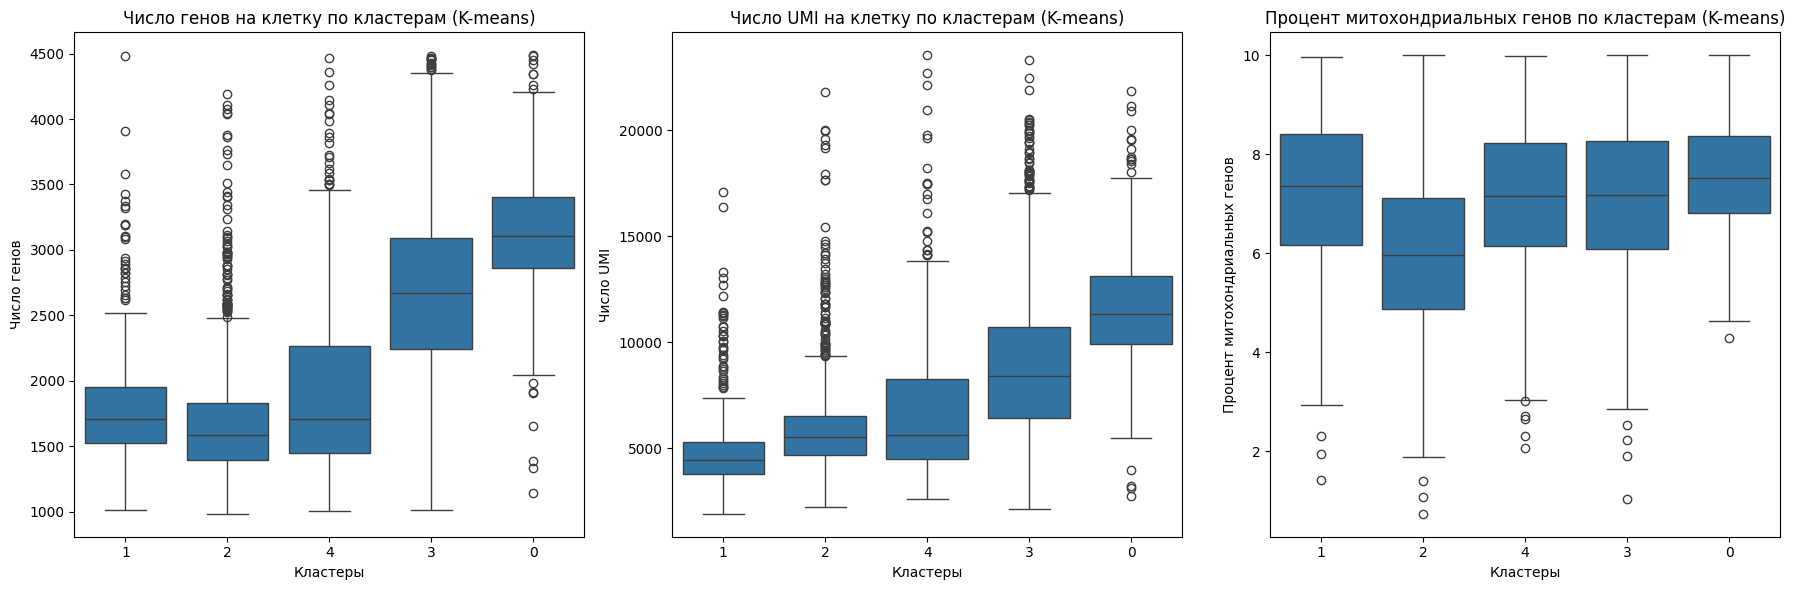

In [105]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Проверяем размер подвыборки
print(f"Размер sample: {sample.X.shape}")

# Выполняем кластеризацию K-means на подвыборке (sample)
kmeans = KMeans(n_clusters=5, random_state=42)
sample.obs['kmeans_cluster'] = kmeans.fit_predict(sample.X).astype(str)

# Проверяем распределение кластеров
print(sample.obs['kmeans_cluster'].value_counts())

# Визуализация распределения кластеров по количеству генов/UMI/проценту митохондрий
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Число генов
sns.boxplot(data=sample.obs, x='kmeans_cluster', y='n_genes_by_counts', ax=axes[0])
axes[0].set_title("Число генов на клетку по кластерам (K-means)")
axes[0].set_xlabel("Кластеры")
axes[0].set_ylabel("Число генов")

# Число UMI
sns.boxplot(data=sample.obs, x='kmeans_cluster', y='total_counts', ax=axes[1])
axes[1].set_title("Число UMI на клетку по кластерам (K-means)")
axes[1].set_xlabel("Кластеры")
axes[1].set_ylabel("Число UMI")

# Процент митохондриальных генов
sns.boxplot(data=sample.obs, x='kmeans_cluster', y='pct_counts_mt', ax=axes[2])
axes[2].set_title("Процент митохондриальных генов по кластерам (K-means)")
axes[2].set_xlabel("Кластеры")
axes[2].set_ylabel("Процент митохондриальных генов")

plt.tight_layout()
plt.show()


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_cluster', the cluster labels (adata.obs, categorical) (0:00:01)
leiden_cluster
0    2426
1    1889
2     396
3     239
4      50
Name: count, dtype: int64


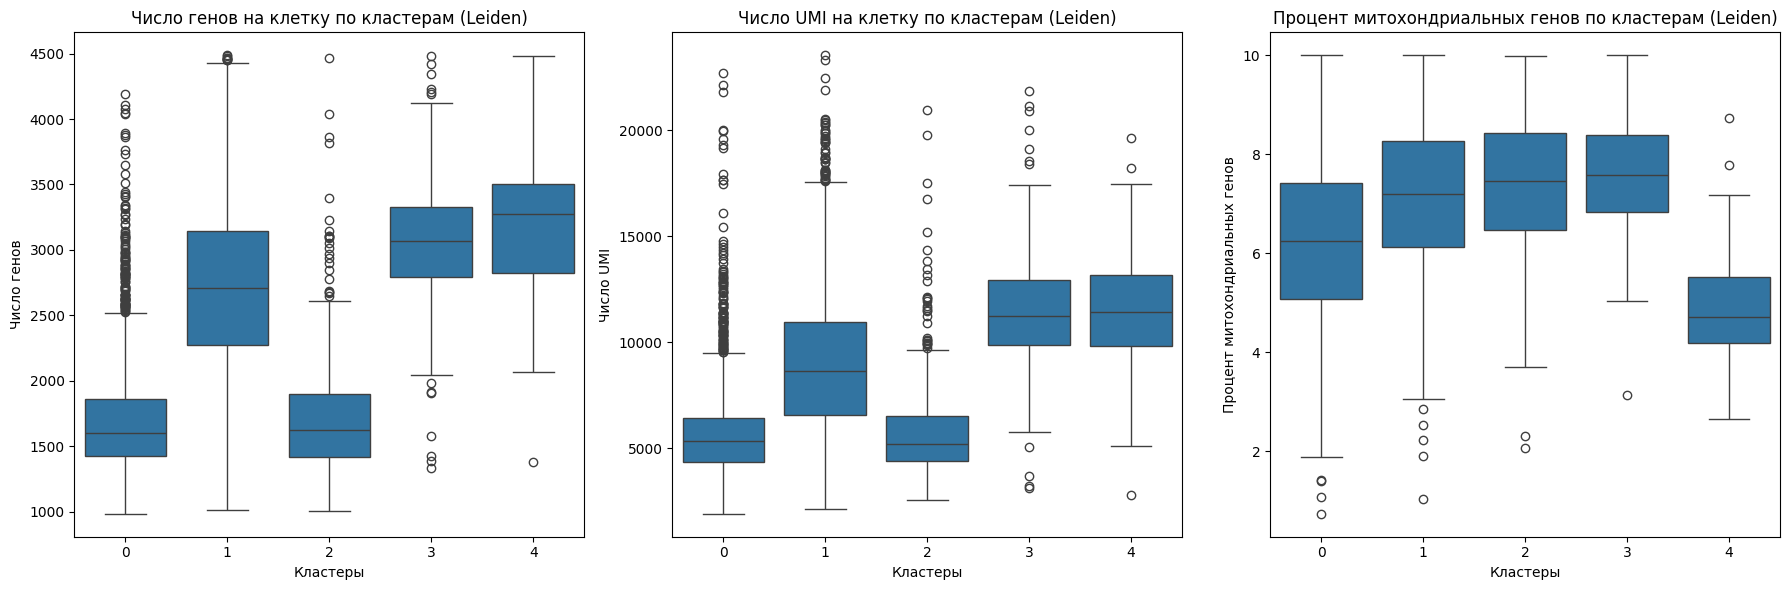

In [106]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Убедимся, что для подвыборки (sample) есть kNN-граф
sc.pp.neighbors(sample, n_neighbors=15, use_rep='X')  # Создаем граф ближайших соседей

# Leiden-кластеризация
sc.tl.leiden(sample, resolution=0.5, key_added='leiden_cluster')  # resolution можно менять

# Проверяем распределение кластеров
print(sample.obs['leiden_cluster'].value_counts())

# Визуализация технических характеристик
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Число генов
sns.boxplot(data=sample.obs, x='leiden_cluster', y='n_genes_by_counts', ax=axes[0])
axes[0].set_title("Число генов на клетку по кластерам (Leiden)")
axes[0].set_xlabel("Кластеры")
axes[0].set_ylabel("Число генов")

# Число UMI
sns.boxplot(data=sample.obs, x='leiden_cluster', y='total_counts', ax=axes[1])
axes[1].set_title("Число UMI на клетку по кластерам (Leiden)")
axes[1].set_xlabel("Кластеры")
axes[1].set_ylabel("Число UMI")

# Процент митохондриальных генов
sns.boxplot(data=sample.obs, x='leiden_cluster', y='pct_counts_mt', ax=axes[2])
axes[2].set_title("Процент митохондриальных генов по кластерам (Leiden)")
axes[2].set_xlabel("Кластеры")
axes[2].set_ylabel("Процент митохондриальных генов")

plt.tight_layout()
plt.show()


* <font color=#c30>**[1]**</font>  Visualize `10` top expressed genes in each cluster. To do this, make use of:
1. `sc.tl.rank_genes_groups` to rank genes for characterizing groups (cluster labels).
  * [Hint] The default statistical method in `rank_gene_groups` is t-test. Think of whether this method is the correct choice here (e.g. Do we have normal distributions in our data?), look up what options do you have in this fuction, and change it if you see the need to do so.
  * [Hint] Also read about `Tie_correct` parameter.
2. `sc.pl.rank_genes_groups` to plot ranking of genes for each cluster.
3. `sc.pl.rank_genes_groups_heatmap` to plot ranking of genes using heatmap plot.\
  * [Hint] Instead of the heatmap, you might want to use some other visualization that you find most fitting. You can use [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html) to find more info about scanpy plotting functions.


In [76]:
# Ранжирование генов для групп (кластеров)
sc.tl.rank_genes_groups(sample, groupby='leiden_cluster', method='wilcoxon', tie_correct=True)

# Просмотр топ-генов для одного из кластеров
sc.get.rank_genes_groups_df(sample, group='0').head(10)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


,names,scores,logfoldchanges,pvals,pvals_adj
0,IL32,59.321358,NaN,0.0,0.0
1,CD3E,58.638130,NaN,0.0,0.0
2,CD3D,57.566212,NaN,0.0,0.0
3,CD3G,56.932545,NaN,0.0,0.0
4,TRAC,56.126553,NaN,0.0,0.0
5,BCL11B,53.415413,NaN,0.0,0.0
6,IL7R,51.798977,NaN,0.0,0.0
7,PCED1B-AS1,51.162720,NaN,0.0,0.0
8,CD2,49.612789,NaN,0.0,0.0
9,LCK,48.600246,NaN,0.0,0.0


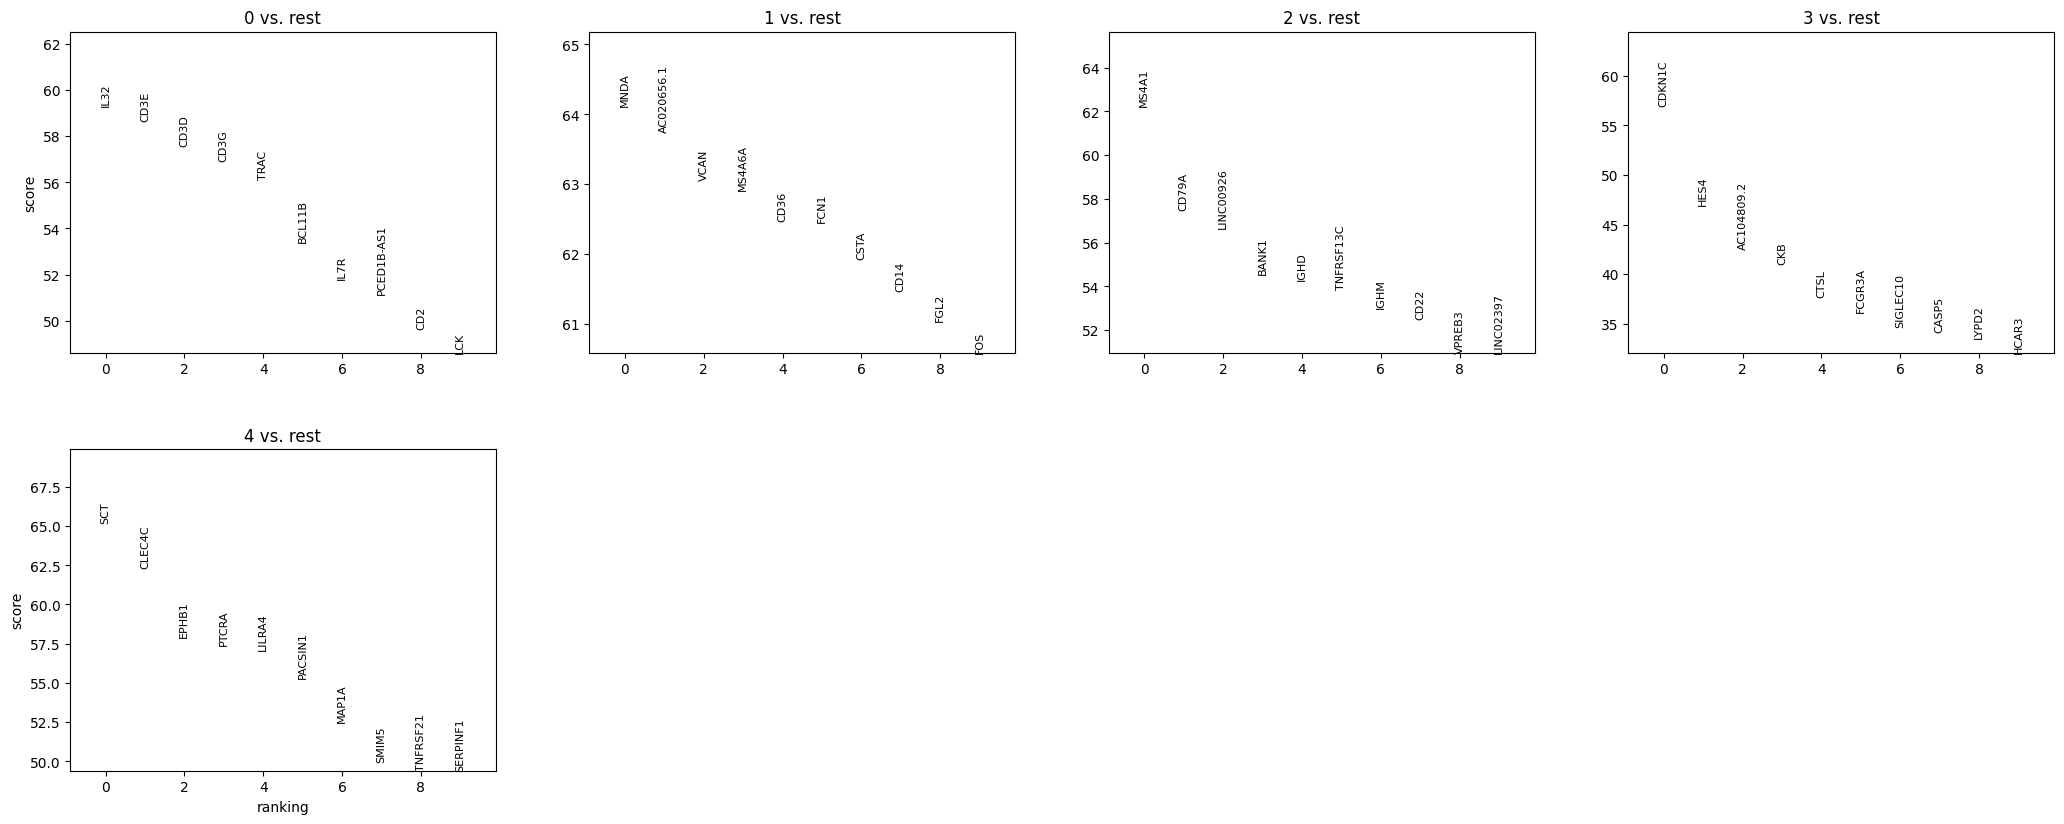

In [77]:
# Барплот для каждого кластера
sc.pl.rank_genes_groups(sample, n_genes=10, sharey=False)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_cluster']`


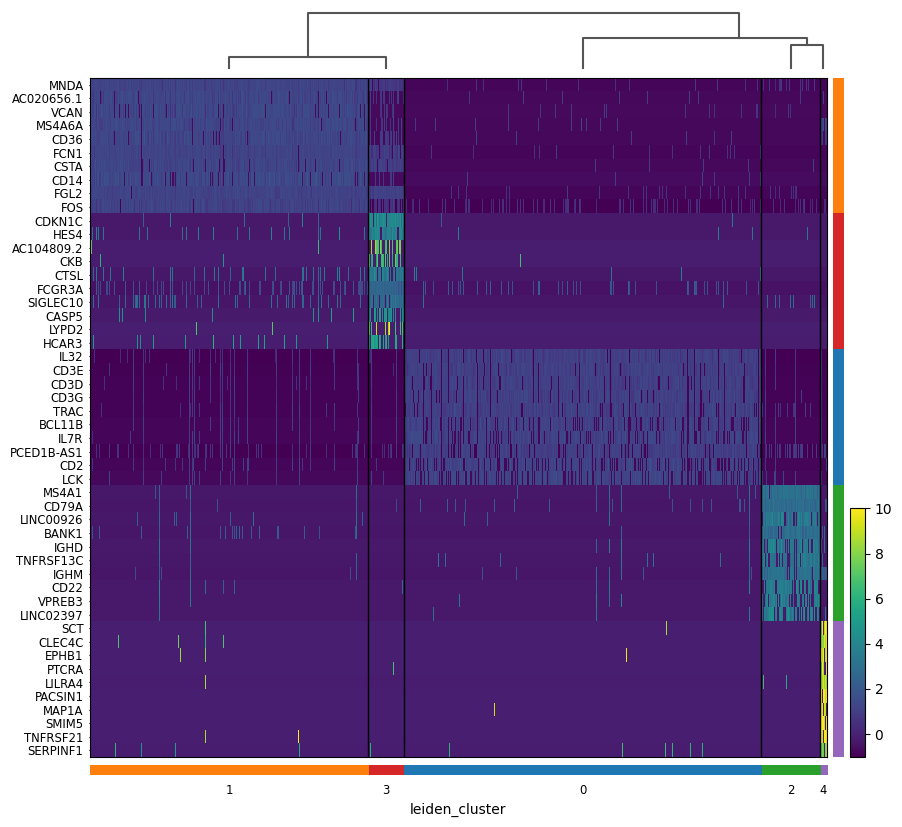

In [78]:
sc.pl.rank_genes_groups_heatmap(sample, n_genes=10, groupby='leiden_cluster', swap_axes=True)


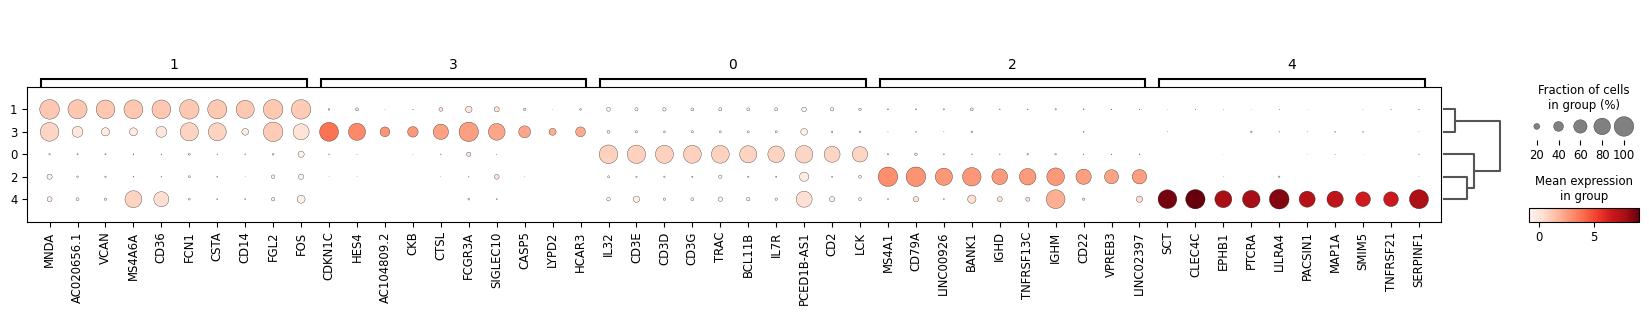

In [79]:
sc.pl.rank_genes_groups_dotplot(sample, n_genes=10, groupby='leiden_cluster')


In [80]:
# Получение таблицы топ-10 генов для каждого кластера
top_genes = sc.get.rank_genes_groups_df(sample, None).groupby('group').head(10)
print(top_genes)


     group       names     scores  logfoldchanges          pvals  \
0        0        IL32  59.321358             NaN   0.000000e+00   
1        0        CD3E  58.638130             NaN   0.000000e+00   
2        0        CD3D  57.566212             NaN   0.000000e+00   
3        0        CD3G  56.932545             NaN   0.000000e+00   
4        0        TRAC  56.126553             NaN   0.000000e+00   
5        0      BCL11B  53.415413             NaN   0.000000e+00   
6        0        IL7R  51.798977             NaN   0.000000e+00   
7        0  PCED1B-AS1  51.162720             NaN   0.000000e+00   
8        0         CD2  49.612789             NaN   0.000000e+00   
9        0         LCK  48.600246             NaN   0.000000e+00   
1825     1        MNDA  64.121620             NaN   0.000000e+00   
1826     1  AC020656.1  63.737503             NaN   0.000000e+00   
1827     1        VCAN  63.052467             NaN   0.000000e+00   
1828     1      MS4A6A  62.915264             Na

<ipython-input-80-4dc4684dbe34>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_genes = sc.get.rank_genes_groups_df(sample, None).groupby('group').head(10)


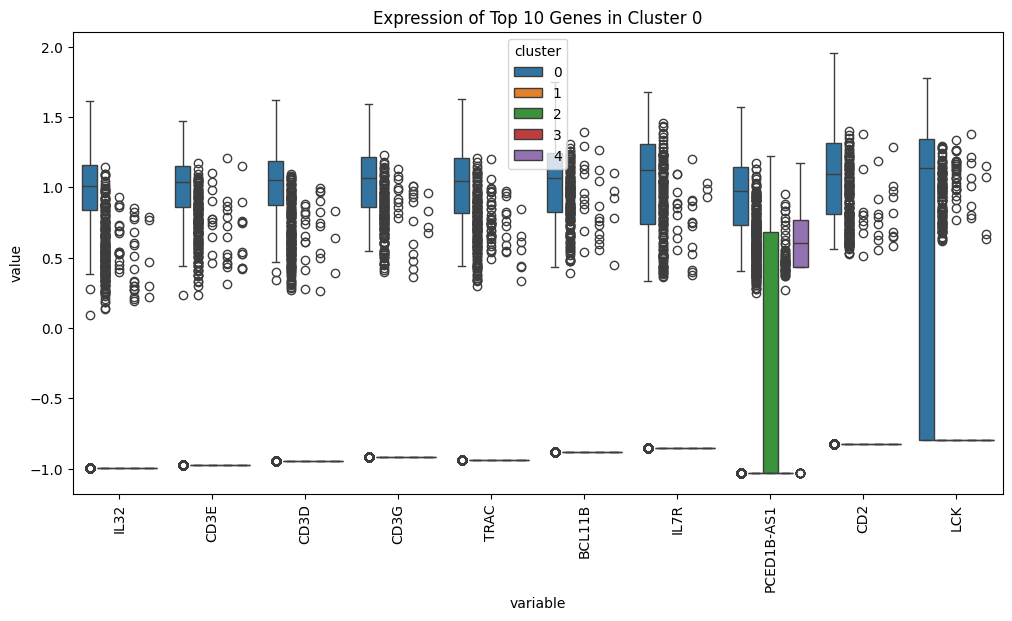

In [81]:
import seaborn as sns

# Топ-10 генов для кластера '0'
cluster_0_top_genes = sc.get.rank_genes_groups_df(sample, group='0')['names'].head(10)

# Выбор данных для этих генов
data = sample[:, cluster_0_top_genes].to_df()
data['cluster'] = sample.obs['leiden_cluster']

# Построение boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.melt(id_vars='cluster'), x='variable', y='value', hue='cluster')
plt.xticks(rotation=90)
plt.title("Expression of Top 10 Genes in Cluster 0")
plt.show()


* <font color=#c30>**[1.5]**</font>  Do one of the following:
  * Either provide formal algorithm and implementation of K-means with random initialization by hand, describe results, and compare them to the sklearn implementation.
  * Or do the same for PCA.\
    *Note that completing both assignments does NOT result in [3.0] points.*

Let's do it for K-means algorithm with synthetic data:

How it works:


1. Initialize _k_ cluster centroids randomly:

2. Randomly choose _k_ points from the data as initial centroids.

- Assign each data point to the nearest centroid:

- Compute the distance (e.g., Euclidean) from each data point to each centroid.
Assign the data point to the cluster with the nearest centroid.
3. Update centroids:
- For each cluster, compute the mean of all data points assigned to that cluster.
- Update the centroid to this mean.

4. Iterate steps 2 and 3 until the centroids do not change significantly or a maximum number of iterations is reached.


<ipython-input-82-706750954e49>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', k)


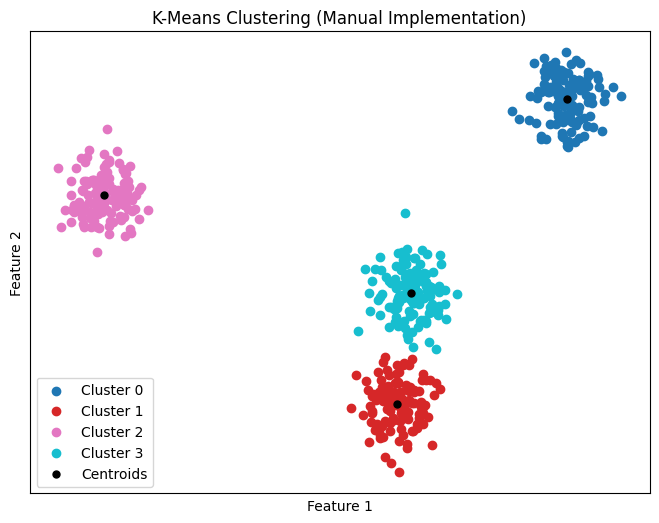

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import cm

# Generate synthetic data
X, y = make_blobs(n_samples=500, centers=4, random_state=123, cluster_std=0.6)

def k_means(X, k, max_iters=200, tol=1e-4, random_state=123):
    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # Randomly initialize centroids
    centroids = X[np.random.choice(n_samples, k, replace=False)]
    prev_centroids = np.zeros_like(centroids)
    labels = np.zeros(n_samples, dtype=int)
    iterations = 0

    while iterations < max_iters and np.linalg.norm(centroids - prev_centroids) > tol:
        prev_centroids = centroids.copy()

        # Assign points to the nearest centroid
        for i in range(n_samples):
            distances = np.linalg.norm(X[i] - centroids, axis=1)
            labels[i] = np.argmin(distances)

        # Update centroids
        for j in range(k):
            points_in_cluster = X[labels == j]
            if len(points_in_cluster) > 0:
                centroids[j] = points_in_cluster.mean(axis=0)

        iterations += 1

    return centroids, labels

# K-means with k=4
k = 4
centroids, labels = k_means(X, k)

colormap = cm.get_cmap('tab10', k)

plt.figure(figsize=(8, 6))
for cluster in range(k):
    plt.scatter(
        X[labels == cluster][:, 0],
        X[labels == cluster][:, 1],
        color=colormap(cluster),
        label=f"Cluster {cluster}"
    )
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='.', s=100, label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title("K-Means Clustering (Manual Implementation)")
plt.show()


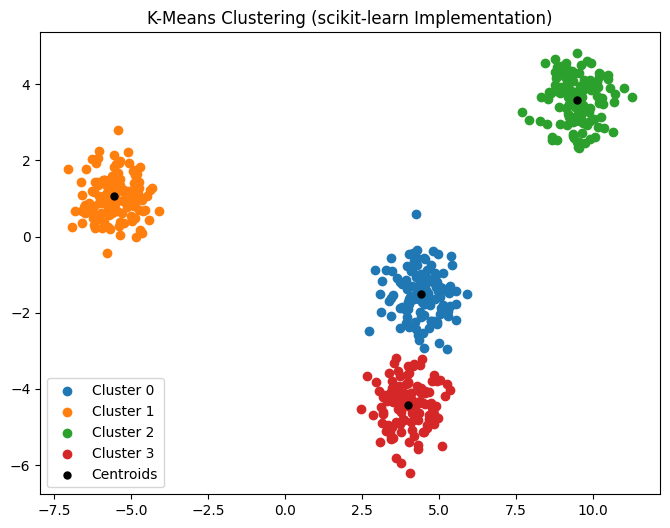

In [83]:
from sklearn.cluster import KMeans

# sklearn K-means
kmeans_sklearn = KMeans(n_clusters=k, random_state=123)
kmeans_sklearn.fit(X)
sklearn_centroids = kmeans_sklearn.cluster_centers_
sklearn_labels = kmeans_sklearn.labels_

plt.figure(figsize=(8, 6))
for cluster in range(k):
    plt.scatter(X[sklearn_labels == cluster][:, 0], X[sklearn_labels == cluster][:, 1], label=f"Cluster {cluster}")
plt.scatter(sklearn_centroids[:, 0], sklearn_centroids[:, 1], c='black', marker='.', s=100, label='Centroids')
plt.legend()
plt.title("K-Means Clustering (scikit-learn Implementation)")
plt.show()


# Extra points <font color=#c30>**[1.5]**</font>



* <font color=#c30>**[1.4]**</font>  Choose 3 clusters of interest and try to make a guess about their cell type based on the top-expressed genes. For example, look for information on whether such high expression of a certain gene is typical of some cell type.
  * Blind answers from ChatGPT won't be accepted. Please look for information from multiple sources, cite them/insert links, and formulate your own opinion.
  * You can also use automatic annotators like Azimuth and Symphony for the whole dataset, but probably it will take much longer time to figure out how they work.

In [84]:
# your code here



You worked hard to get here, and we hope you learned something new!
Each year we gather impressions and suggestions regarding our course in order to improve it. Find time to write a review here or in anonymous form (can be found on github course page).

The last task:

* <font color=#c30>**[0.1]**</font>  To greatly increase the chances of your success in the bioinformatics field, find a funny meme (about your favourite subject, like ML, molecular biology, etc.) and attach it here.

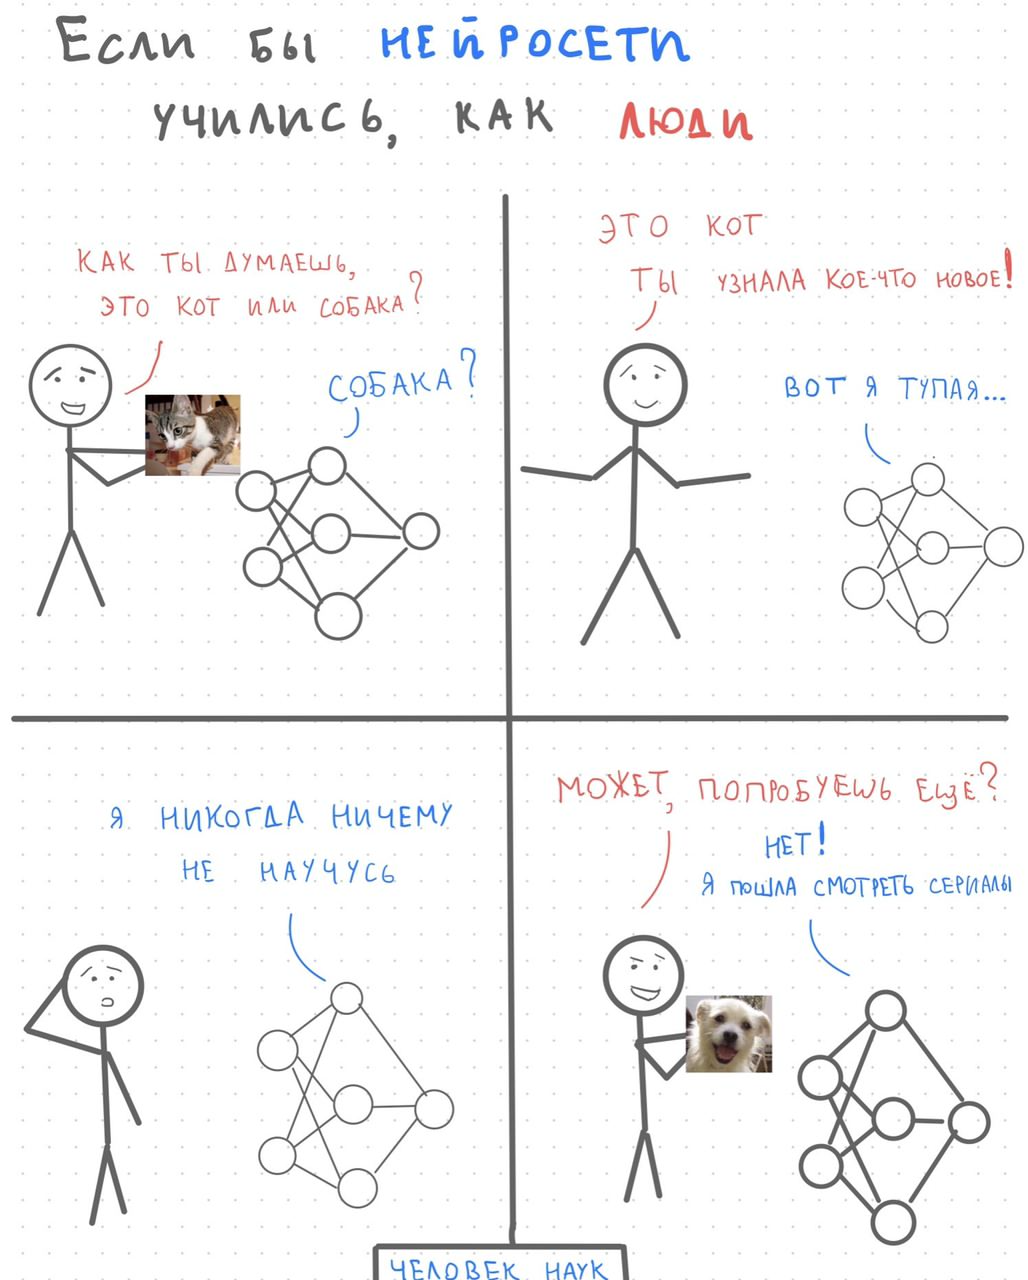